In [9]:
import matplotlib.pyplot as plt
import tifffile as tf
import cv2
import math as m
from skimage.measure import regionprops
import colorcet as cc
import numpy as np
from skimage.morphology import disk
import scipy.ndimage as ndi
# define qualitative colormap
glasbey = cc.cm.glasbey_dark_r

In [10]:
preprocessed = cv2.imread(r"Fig1\1806_G1_225t(1848,3896,5544,7592)_preprocessed.png")
pred = cv2.imread(r"Fig1\1806_G1_225t(1848,3896,5544,7592)_predicted.png")
seg_inner = tf.imread(r"Fig1\1806_G1_225t.tif_inner_labeled.tif")
seg_outer = tf.imread(r"Fig1\1806_G1_225t.tif_outer_labeled.tif")

table = cv2.imread(r"Fig1\Fig1_table.png")
px_size = 4.3*4 #nm*ds

In [11]:
# define region of the image to display
x_0 = 100
x_1 = 900
y_0 = 100
y_1 = 900

x_c = 5544 # number of pixels to correct in x and y axis for fused prediction image
y_c  = 1848

x_0_c = x_0 + x_c # corrected x & y coordinates
x_1_c = x_1 + x_c
y_0_c = y_0 + y_c
y_1_c = y_1 + y_c

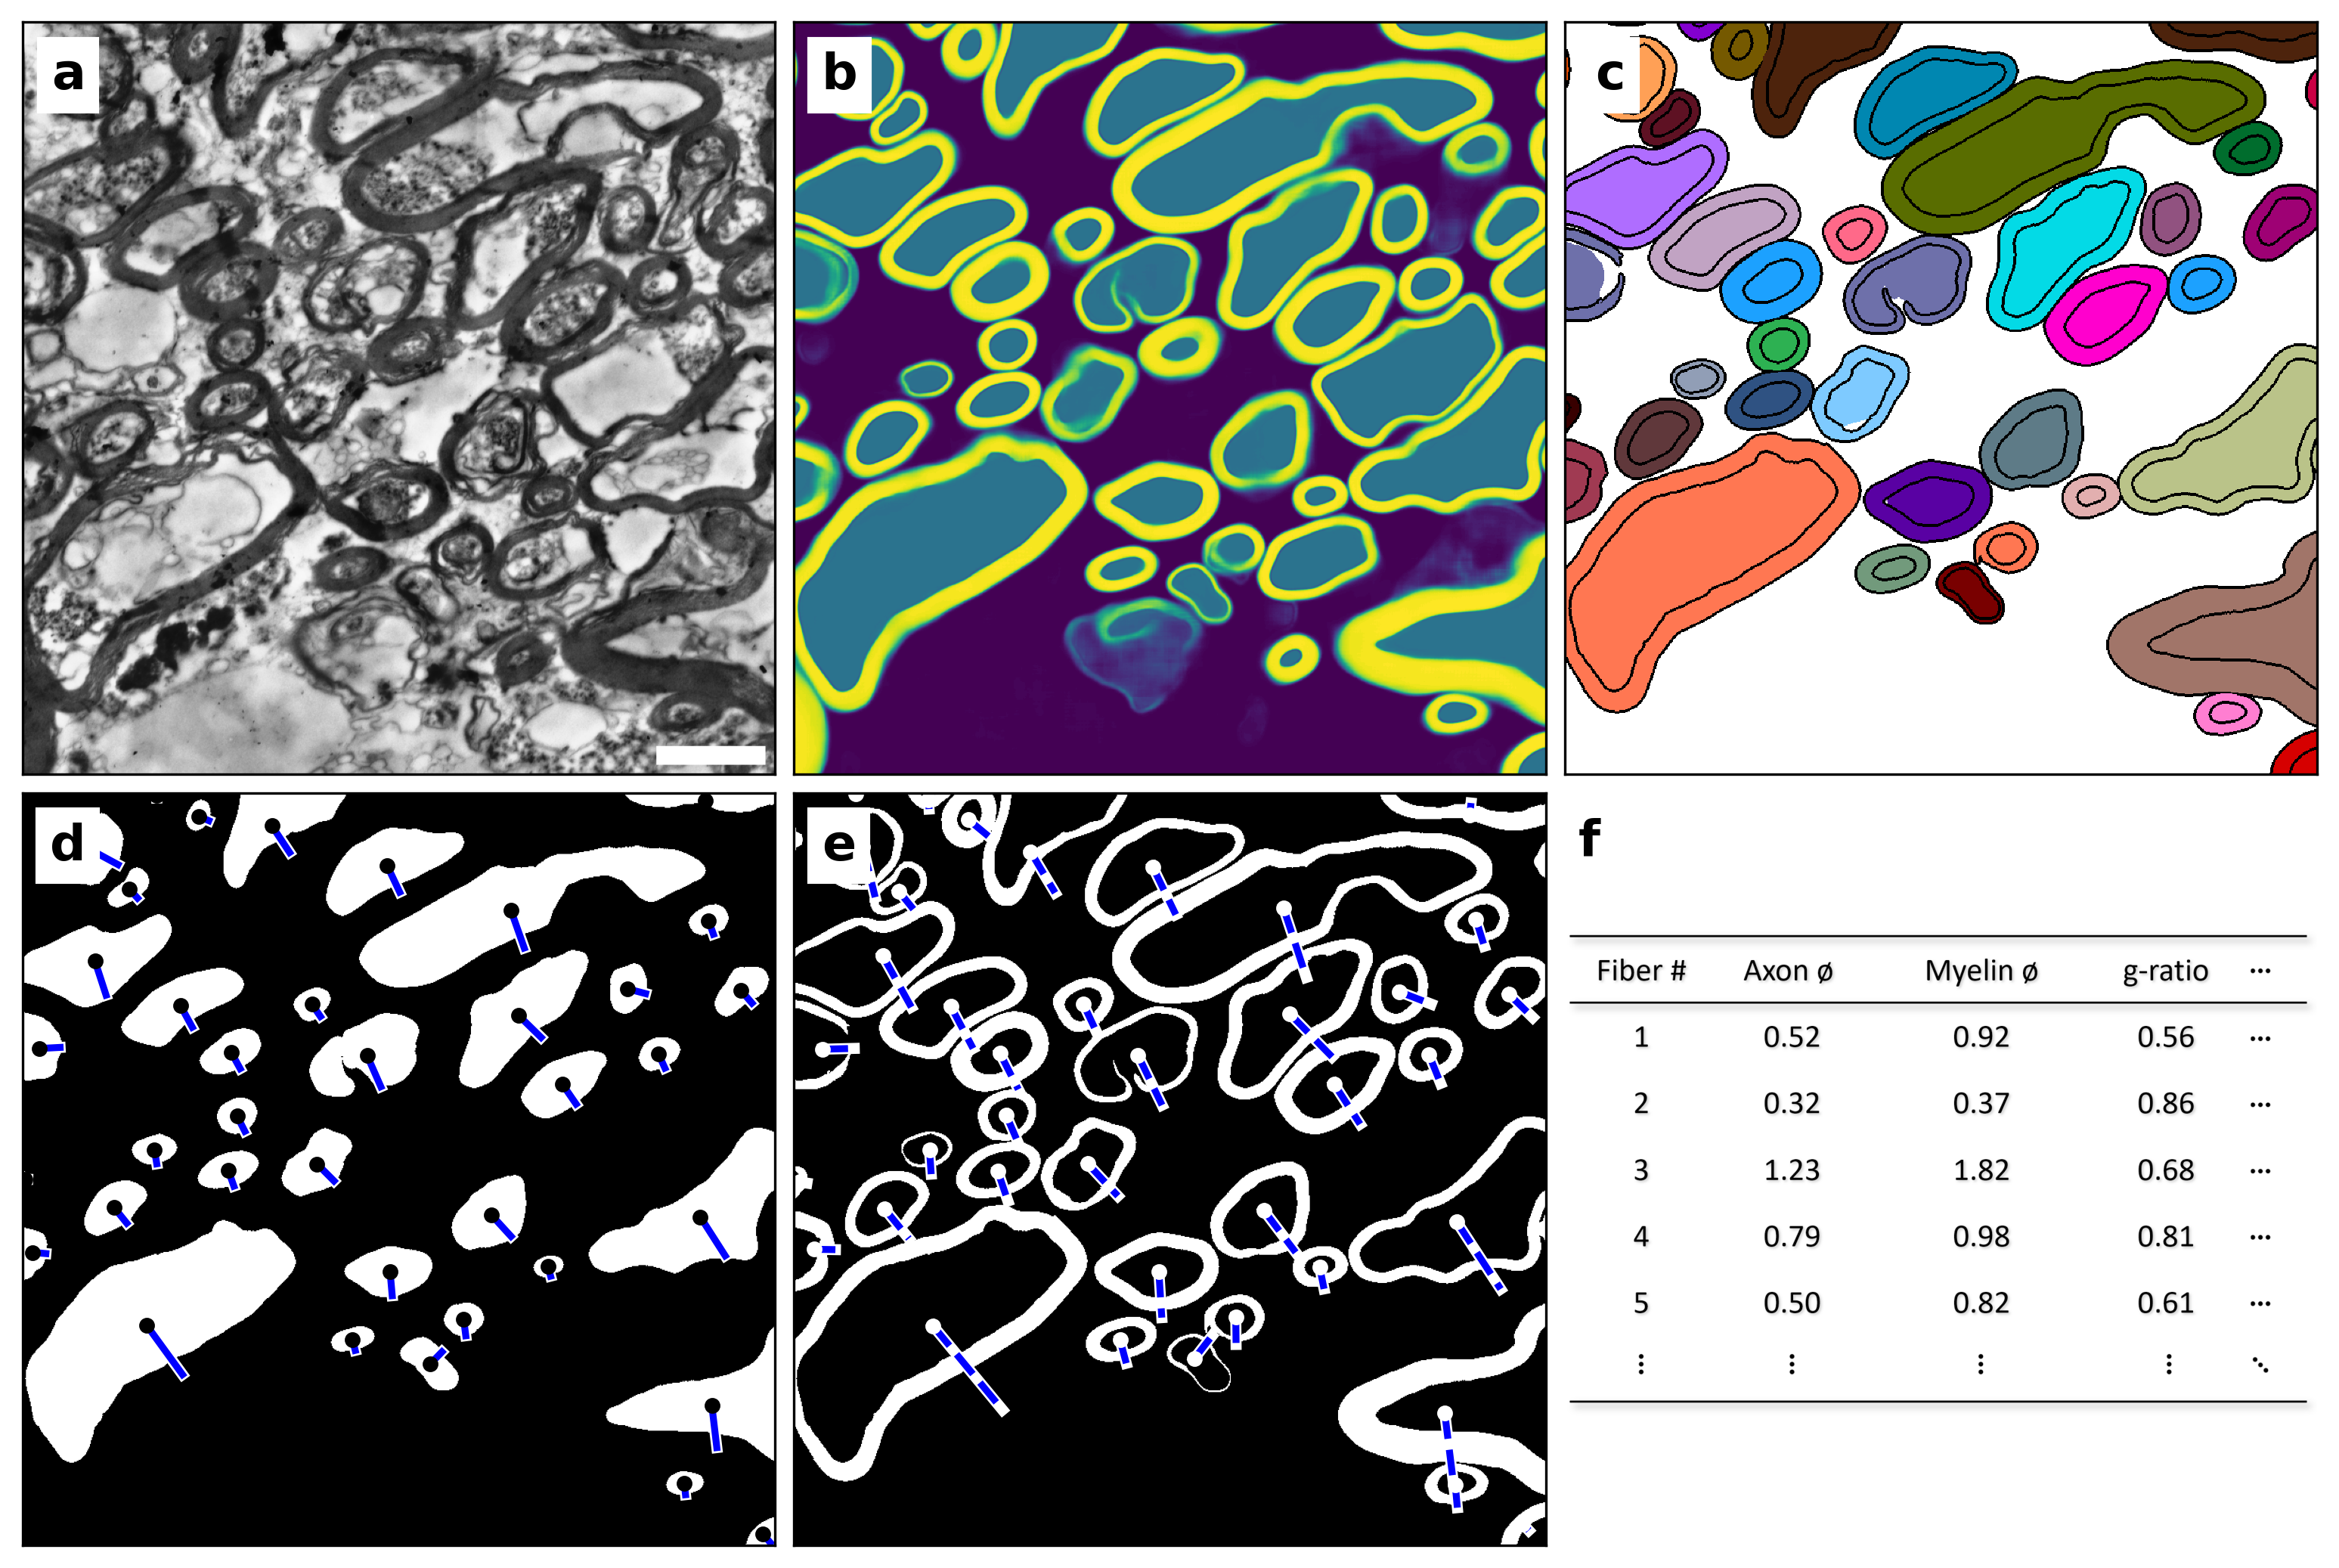

In [12]:
txt_displace_x = 48
txt_displace_y = 56

# need to constrain segmentations by 100px on each axis so they are aligned
seg_inner = seg_inner[y_0_c-100:y_1_c-100,x_0_c-100:x_1_c-100]
seg_outer = seg_outer[y_0_c-100:y_1_c-100,x_0_c-100:x_1_c-100]

ax = plt.figure(layout="constrained",figsize=(10.2,10.2*2/3),dpi=300).subplot_mosaic(
    """
    aaabbbccc
    dddeeefff
    """)

img_a = preprocessed[y_0:y_1,x_0:x_1]

# burn-in scale bar of 2µm
img_a[770:790,790-int(2000/px_size):790] = 255
# ax["a"].imshow(preprocessed[y_0:y_1,x_0:x_1])
ax["a"].imshow(img_a)

ax["b"].imshow(pred[y_0:y_1,x_0:x_1,0],cmap='viridis')

# generate instance segmentation picture
outer_dilated = ndi.binary_dilation(seg_outer,disk(3))
ero = np.logical_xor(seg_outer.astype('bool'),outer_dilated)
vmin = 2
vmax = seg_inner.max()
# ax["C"].imshow(np.zeros_like(seg_inner), cmap='gray',interpolation='None') # black background
ax["c"].imshow(np.ma.array(seg_inner + seg_outer, mask=(seg_inner + seg_outer) == 0), cmap=glasbey,vmin=vmin,vmax=vmax,interpolation='None')
ax["c"].imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)

image_shape = seg_inner.shape
for plot_key in ['d', 'e']:
    ax[plot_key].set_xlim(0, image_shape[1])
    ax[plot_key].set_ylim(image_shape[0], 0)

ax["d"].imshow(seg_inner.astype('bool'), cmap=plt.cm.gray,aspect=1)
regions = regionprops(seg_inner)
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.minor_axis_length
    # x2 = x0 - m.sin(orientation) * 0.5 * props.major_axis_length
    # y2 = y0 - m.cos(orientation) * 0.5 * props.major_axis_length

    ax["d"].plot((x0, x1), (y0, y1), 'white', linewidth=3.5)
    ax["d"].plot((x0, x1), (y0, y1), 'blue', linewidth=2.2)
    # ax["d"].plot((x0, x2), (y0, y2), 'blue', linewidth=1.5,linestyle="--")
    ax["d"].plot(x0, y0, '.k', markersize=8)

ax["e"].imshow(seg_outer.astype('bool'), cmap=plt.cm.gray)
regions = regionprops(seg_outer)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.minor_axis_length
    # x2 = x0 - m.sin(orientation) * 0.5 * props.major_axis_length
    # y2 = y0 - m.cos(orientation) * 0.5 * props.major_axis_length

    ax["e"].plot((x0, x1), (y0, y1), 'white', linewidth=3.5,)
    ax["e"].plot((x0, x1), (y0, y1), 'blue', linewidth=2.2, linestyle="--")
    # ax["e"].plot((x0, x2), (y0, y2), 'blue', linewidth=1.5,linestyle="--")
    ax["e"].plot(x0, y0, '.w', markersize=8)

for key in ax:
    ax[key].set_xticks([])
    ax[key].set_yticks([])
    ax[key].set_xticklabels([])
    ax[key].set_yticklabels([])
    if key == "f":
            ax[key].text(txt_displace_x, txt_displace_y-216, key, color='black', ha='center', va='center', fontsize=16, backgroundcolor='white',weight='bold')#
            continue
    ax[key].text(txt_displace_x, txt_displace_y, key, color='black', ha='center', va='center', fontsize=16, backgroundcolor='white',weight='bold')#

ax["f"].imshow(table)
ax["f"].set_frame_on(False)

plt.show()